# Variational Autoencoder with PyTorch v PCA 

## Imports 

In [59]:
import numpy as np 
import pandas as pd 
import sys
import os
import inspect
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn import preprocessing
DATA_PATH = 'wine.csv'
# Set the device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define Functions 

In [68]:
def load_data(path):
    # read in from csv
    df = pd.read_csv(DATA_PATH, sep=',', header=None, names=['Wine', 'Alcohol','Malic.acid','Ash','Acl',
                                                    'Mg', 'Phenols', 'Flavanoids','Nonflavanoid.phenols',
                                                    'Proanth','Color.int','Hue', 'OD','Proline'])
    
    
    # Convert all columns to float
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    df = df.dropna()
    
    # replace nan with -99
    df = df.fillna(-99)
    df_base = df.iloc[:, 1:]
    df.shape
    # get wine Label
    df_wine = df.iloc[:,0].values
    x = df_base.values.reshape(-1, df_base.shape[1]).astype('float32')
    # stadardize values
    standardizer = preprocessing.StandardScaler()
    x = standardizer.fit_transform(x)    
    return x, standardizer, df_wine

In [61]:
def numpyToTensor(x):
    x_train = torch.from_numpy(x).to(device)
    return x_train

# Create PCA with 3 dimensions

In [62]:
x_pca, standardizer, df_wine = load_data(DATA_PATH)

shape before removing na (179, 14)
shape after removing na (178, 14)


In [64]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x_pca)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

In [65]:
finalDf = pd.concat([principalDf, pd.DataFrame(df_wine, columns = ['wine'])], axis = 1)
finalDf.head()

,principal component 1,principal component 2,principal component 3,wine
0,3.316750,-1.443462,-0.165739,1.0
1,2.209467,0.333392,-2.026457,1.0
2,2.516741,-1.031153,0.982821,1.0
3,3.757066,-2.756373,-0.176192,1.0
4,1.008909,-0.869831,2.026688,1.0


## Build Data Loader 

In [69]:
from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, path):
        self.x, self.standardizer, self.wine = load_data(DATA_PATH)
        self.x = numpyToTensor(self.x)
        self.len=self.x.shape[0]
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

In [70]:
data_set=DataBuilder(DATA_PATH)
trainloader=DataLoader(dataset=data_set,batch_size=1024)

In [71]:
type(trainloader.dataset.x)

torch.Tensor

In [72]:
data_set.x

tensor([[ 1.5186, -0.5622,  0.2321,  ...,  0.3622,  1.8479,  1.0130],
        [ 0.2463, -0.4994, -0.8280,  ...,  0.4061,  1.1134,  0.9652],
        [ 0.1969,  0.0212,  1.1093,  ...,  0.3183,  0.7886,  1.3951],
        ...,
        [ 0.3328,  1.7447, -0.3894,  ..., -1.6121, -1.4854,  0.2806],
        [ 0.2092,  0.2277,  0.0127,  ..., -1.5683, -1.4007,  0.2965],
        [ 1.3951,  1.5832,  1.3652,  ..., -1.5244, -1.4289, -0.5952]])

In [73]:
class Autoencoder(nn.Module):
    def __init__(self,D_in,H=50,H2=12,latent_dim=3):
        
        #Encoder
        super(Autoencoder,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2=nn.Linear(H,H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3=nn.Linear(H2,H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)
        
#         # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

#         # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)
        
#         # Decoder
        self.linear4=nn.Linear(H2,H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5=nn.Linear(H2,H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6=nn.Linear(H,D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)
        
        self.relu = nn.ReLU()
        
    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))


        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        # self.decode(z) ist später recon_batch, mu ist mu und logvar ist logvar
        return self.decode(z), mu, logvar

In [74]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    # x_recon ist der im forward im Model erstellte recon_batch, x ist der originale x Batch, mu ist mu und logvar ist logvar 
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

In [75]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [76]:
D_in = data_set.x.shape[1]
H = 50
H2 = 12
model = Autoencoder(D_in, H, H2).to(device)
model.apply(weights_init_uniform_rule)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [77]:
loss_mse = customLoss()

## Train Model 

In [78]:
epochs = 5000
log_interval = 50
val_losses = []
train_losses = []

In [79]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
#       
    if epoch % 200 == 0:        
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))

In [80]:
for epoch in range(1, epochs + 1):
    train(epoch)

====> Epoch: 200 Average loss: 11.4298
====> Epoch: 400 Average loss: 9.1613
====> Epoch: 600 Average loss: 9.0011
====> Epoch: 800 Average loss: 8.0535
====> Epoch: 1000 Average loss: 7.8984
====> Epoch: 1200 Average loss: 7.6653
====> Epoch: 1400 Average loss: 7.5282
====> Epoch: 1600 Average loss: 7.5492
====> Epoch: 1800 Average loss: 7.3987
====> Epoch: 2000 Average loss: 7.3375
====> Epoch: 2200 Average loss: 7.2048
====> Epoch: 2400 Average loss: 6.9952
====> Epoch: 2600 Average loss: 7.1077
====> Epoch: 2800 Average loss: 6.8111
====> Epoch: 3000 Average loss: 6.7366
====> Epoch: 3200 Average loss: 6.4933
====> Epoch: 3400 Average loss: 6.6501
====> Epoch: 3600 Average loss: 6.5211
====> Epoch: 3800 Average loss: 6.2793
====> Epoch: 4000 Average loss: 6.5038
====> Epoch: 4200 Average loss: 6.6130
====> Epoch: 4400 Average loss: 6.5371
====> Epoch: 4600 Average loss: 6.3893
====> Epoch: 4800 Average loss: 6.3553
====> Epoch: 5000 Average loss: 6.5422


## Evaluate 

In [81]:
standardizer = trainloader.dataset.standardizer

In [82]:
model.eval()
test_loss = 0
# no_grad() bedeutet wir nehmen die vorher berechneten Gewichte und erneuern sie nicht
with torch.no_grad():
    for i, data in enumerate(trainloader):
        data = data.to(device)
        recon_batch, mu, logvar = model(data)

In [83]:
recon_batch.shape

torch.Size([178, 13])

In [84]:
standardizer.inverse_transform(recon_batch[65].reshape(1,-1).cpu().numpy())

array([[1.2221923e+01, 1.4362212e+00, 2.2272756e+00, 1.8828455e+01,
        9.1956886e+01, 2.9888983e+00, 2.7276361e+00, 2.4367350e-01,
        1.8134533e+00, 3.7175090e+00, 1.0500692e+00, 3.0016959e+00,
        5.9834357e+02]], dtype=float32)

In [85]:
standardizer.inverse_transform(data[65].reshape(1, -1).cpu().numpy())

array([[1.237e+01, 1.210e+00, 2.560e+00, 1.810e+01, 9.800e+01, 2.420e+00,
        2.650e+00, 3.700e-01, 2.080e+00, 4.600e+00, 1.190e+00, 2.300e+00,
        6.780e+02]], dtype=float32)

The recon_batch is the reconstructed data. So after putting the data through the encoder we compress the dimensions to 3 (embeddings). With these 3 representaions/embeddings of each row the decoder tries to convert it back to the original data. So basically, this recontructed row feeds itself from only three numbers.

## Get Embeddings 

In [86]:
mu_output = []
logvar_output = []

with torch.no_grad():
    for i, (data) in enumerate(trainloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)

            
            mu_tensor = mu   
            mu_output.append(mu_tensor)
            mu_result = torch.cat(mu_output, dim=0)

            logvar_tensor = logvar   
            logvar_output.append(logvar_tensor)
            logvar_result = torch.cat(logvar_output, dim=0)

In [87]:
mu_result.shape

torch.Size([178, 3])

In [88]:
mu_result[1:5,:]

tensor([[-2.7590e-03,  7.4331e-01, -7.0814e-01],
        [ 7.1097e-04, -3.1500e-02, -1.1394e+00],
        [-9.1275e-04,  2.2923e-01, -1.6690e+00],
        [ 7.9826e-03, -1.3839e+00, -7.8933e-01]])

These are the embeddings calculated by our VAE.

# Plot Embeddings of PCA 

In [89]:
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

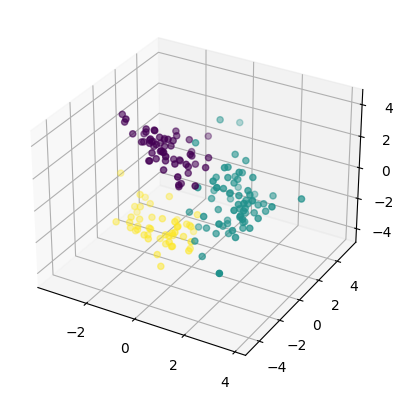

In [90]:


ax = plt.axes(projection='3d')


# Data for three-dimensional scattered points
winetype = finalDf.iloc[:,3].values
zdata = finalDf.iloc[:,0].values
xdata = finalDf.iloc[:,1].values
ydata = finalDf.iloc[:,2].values
ax.scatter3D(xdata, ydata, zdata, c=winetype);



# Plot Embeddings from VAE 

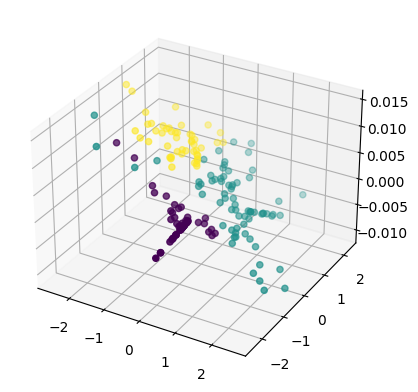

In [91]:
ax = plt.axes(projection='3d')


# Data for three-dimensional scattered points
winetype = data_set.wine
zdata = mu_result[:,0].cpu().numpy()
xdata = mu_result[:,1].cpu().numpy()
ydata = mu_result[:,2].cpu().numpy()
ax.scatter3D(xdata, ydata, zdata, c=winetype);

https://github.com/sdv-dev/SDV